In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#import h5py
import pandas as pd
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d

In [7]:
# Get training data
store = pd.HDFStore('/home/data/School/CIRES/chapt_1/April_20th_wfs.h5','r')
raw = store['raw'] 
xtrain = raw.iloc[:60000,4:]/7631.1981111086952
xtest = raw.iloc[60000:70000,4:]/7631.1981111086952
xtest = xtest.values

# Temp, clean training

xtrain = xtrain.values[list(set(r_[0:60000:1]) - 
                                 set((653,1144,2493,6277,
                                      8973,9469,14524,21953,22281,22395,
                                      22836,29706,33711,34579,35848,35915,
                                      45733,46918,48443,49895,56860,58161))),:]


In [13]:
set(raw.iloc[2494])

{0.0,
 0.04988877838026484,
 0.051198897433550807,
 0.19971781684651357,
 0.9588680394469989,
 4.438503415292276,
 8.456444262422922,
 17.525015309464855,
 55.5867619267885,
 90.47778922617807,
 135.40719638350822,
 360.0239342970709,
 417.8229409815425,
 895.7511559451005,
 1002.1432836560439,
 1437.8194472003702,
 1555.732122852011,
 1648.7538421207921}

In [368]:
#list(set(r_[0:60000:1]) - set((653,1144,2493,6277,
#8973,9469,14524,21953,22281,22395,
#22836,29706,33711,34579,35848,35915,
#45733,46918,48443,49895,56860,58161)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
np.random.randint

In [366]:
# Get empirical noise
orgin = h5py.File('/Users/grigsbye/Downloads/GLAH01_033_1102_028_0090_1_02_0001.H5')
dataset40 = orgin['Data_40HZ']
valid_bool = dataset40['Waveform']['Characteristics']['i_waveformType'][:]==1
signals = np.max(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool],axis=1) > 0.1
noise_sub = dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,200:].flatten()
noise_pool=noise_sub[(noise_sub <.06)*(noise_sub > -0.06)].ravel()

SyntaxError: invalid syntax (<ipython-input-366-2954e62cddca>, line 1)

In [205]:
# Get empirical scaling factors
my_sigs = dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:]
widthDist = np.load('/Users/grigsbye/Desktop/orbit_width_counts-idx.npy')

# widths 5 to 99
maxes = []
for i in range(5,100):
    mynum = []
    for j in range(-5,5):
        mynum.append(np.max(my_sigs[widthDist[i+j,:],:],axis=1).tolist())
    maxes.append([item for sublist in mynum for item in sublist])
    
# widths > 100 ; treated as a single population
cache = []
for i in range(100,540):
    cache.append(np.max(my_sigs[widthDist[i,:],:],axis=1).tolist())
    maxes_over_100ns = [item for sublist in cache for item in sublist]
maxes_over_100ns = np.array(maxes_over_100ns)

In [230]:
# Generator for random noise
# Returns 1 of 1.7 million valid noise vectors
def return_noise():
    while True:
        y_start = random.choice(r_[0:2290156:544][:-1]) + randint(0,460)
        y_noise = noise_pool[y_start:y_start + 544]
        if max(np.abs(y_noise[:-1] - y_noise[1:])) < .045:
            yield y_noise
        else:
            pass #yield return_noise(y)

In [231]:
noise = return_noise()

def scale_and_noise(shifted_wf, width):
    if width < 100:
        peak = np.random.choice(np.array(maxes[width-5]))
    else:
        peak =np.random.choice(maxes_over_100ns)
    shifted_wf = (shifted_wf / max(shifted_wf)) * peak
    return shifted_wf[:] + noise.__next__()[4:]
    

In [348]:
#np.nonzero(y[:,3:])[1].min()
y = gaussian_filter1d(xtrain.as_matrix(),.8,axis=1)
for i, item in enumerate(y):
    if len(np.nonzero(item)[0]) <= 1:
        print(i)
    

653
1144
2493
6277
8973
9469
14524
21953
22281
22395
22836
29706
33711
34579
35848
35915
45733
46918
48443
49895
56860
58161


In [322]:
# Function for offsets
offsets = np.argmax(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:] > 0.1,axis=1)
def return_shifted(conv_training_wf):
    bounds_arr = np.nonzero(conv_training_wf)[0]
    #min_max = bounds_arr[::max(1, len(testing)-1)]
    candidate = random.choice(offsets)
    while candidate >= (542 - bounds_arr[-1]):
        candidate = random.choice(offsets)
    shifted = np.zeros_like(conv_training_wf)
    length = bounds_arr[-1] - bounds_arr[0]
    #print(length,candidate,candidate+length)
    shifted[candidate:candidate+length] = conv_training_wf[bounds_arr[0]:bounds_arr[-1]]
    scaled = scale_and_noise(shifted, length)
    return scaled
    #if candidate < (540 - bounds_arr[-1]):

In [371]:
# Function to get data

def get_data(number_of_wfs_to_get):
    n = number_of_wfs_to_get
    idx = np.random.choice(r_[0:len(xtrain):1],n,replace=False)
    #y = gaussian_filter1d(xtrain.as_matrix()[idx,:],.8,axis=1)
    y = gaussian_filter1d(xtrain[idx,:],.8,axis=1)
    offset_with_noise = np.zeros_like(y)
    for i, wf in enumerate(y):
        offset_with_noise[i] = return_shifted(wf)
    return offset_with_noise, y, idx

In [330]:
idx = np.random.choice(r_[0:len(xtrain):1],10000,replace=False)
y = gaussian_filter1d(xtrain.as_matrix()[idx,:],.8,axis=1)
offset_with_noise = np.zeros_like(y)



In [374]:
x, y, indx = get_data(1000)
#len(xtrain)

In [278]:
x, y, indx = get_data(10)

65 61 126
26 49 75
15 105 120
512 21 533
19 57 76
51 44 95
138 67 205
76 49 125
174 46 220
41 46 87


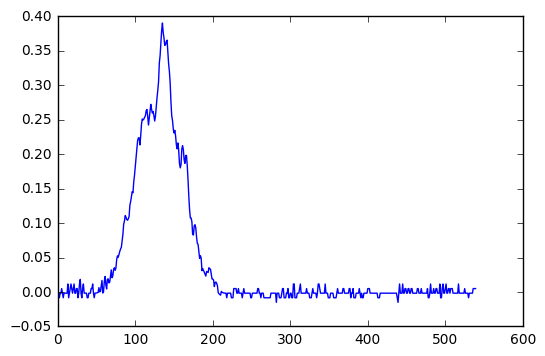

In [378]:
plot(x[60])

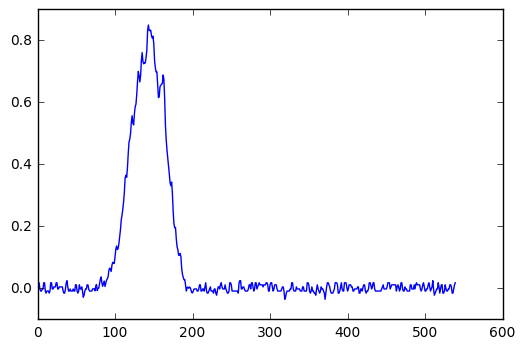

In [293]:
plot(x[6])

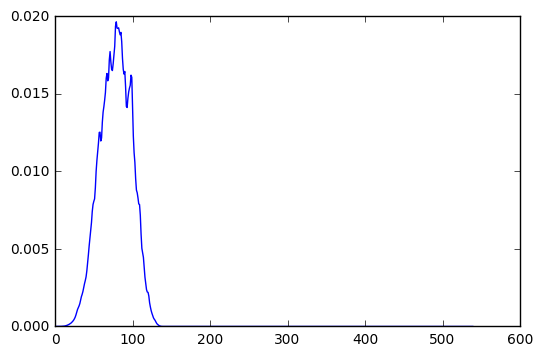

In [294]:
plot(y[6])

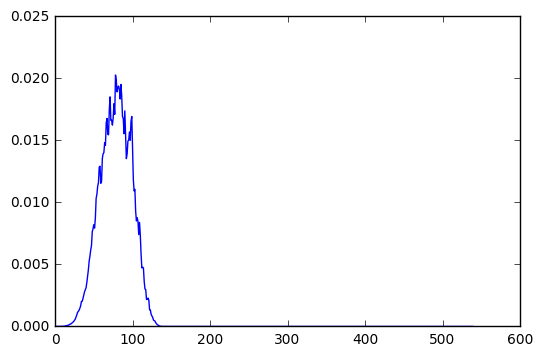

In [295]:
plot(xtrain.as_matrix()[indx[6]])

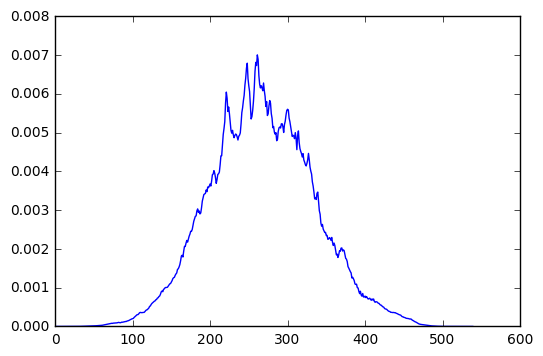

In [291]:
plot(y[3])

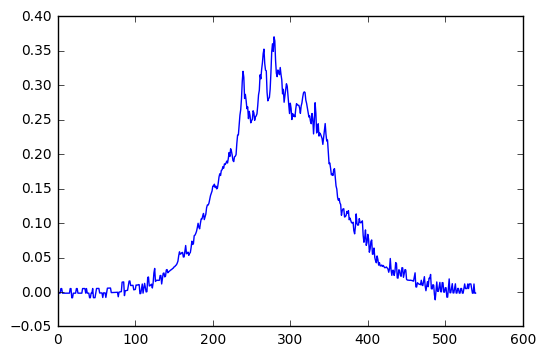

In [285]:
plot(x[3])

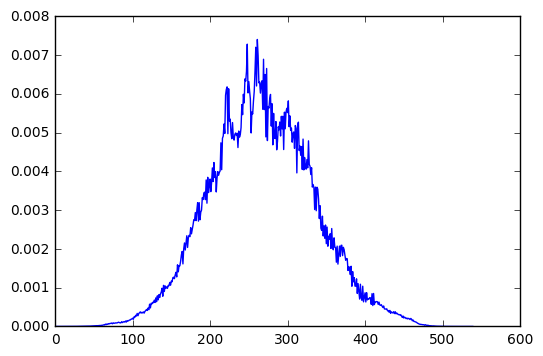

In [286]:
plot(xtrain.as_matrix()[indx[3]])

In [5]:
noise = return_noise()

In [183]:
testing1 = gaussian_filter1d(xtest[1610,:],.8)
testing = np.nonzero(testing1)[0]
testing[::max(1, len(testing)-1)],testing[-1]
540-18
521+18
test = np.random.choice(r_[0:len(xtrain):1],10000,replace=False)
#r_[0:len(xtrain):1]
testing5 = gaussian_filter1d(xtrain.as_matrix()[test,:],.8,axis=0)
#testing1.shape
i = 0
for wf in testing5:
    i+=1
    if i == 255:
        print(wf,len(wf))


[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   4.04473745e-05   2.45969977e-04
   2.14098951e-03   1.31807025e-02   4.09945945e-02   6.10101422e-02
   8.41583219e-02   8.64357579e-02   4.88480056e-02   5.84945488e-02
   7.00667411e-02   8.26294059e-02   1.13638712e-01   7.88354072e-02
   8.02050364e-02   5.69036503e-02   3.39649872e-02   2.60296044e-02
   2.32095506e-02   1.18588885e-02   4.70975804e-03   2.05662792e-03
   8.83612442e-04   5.53945496e-04   6.81322659e-04   5.69641011e-04
   3.61486026e-04   3.32610726e-04   2.68320576e-04   1.92384360e-04
   2.13025495e-04   2.27273725e-04   2.20609453e-04   2.12021811e-04
   2.30773259e-04   3.87729116e-04   4.00830920e-04   4.12875622e-04
   3.79432838e-04   4.21588241e-04   3.57539987e-04   3.45763690e-04
   3.41074000e-04   3.70364639e-04   3.68752895e-04   3.64883507e-04
   3.45559065e-04   3.44406097e-04   3.18215072e-04   3.12959980e-04
   3.69969799e-04   3.79810148e-04

In [207]:
#plot(noise.next())
len(noise.__next__())

544

In [12]:
sum(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:] > 0.1,axis=1) > 28

array([False, False, False, ..., False, False, False], dtype=bool)

In [16]:
widthDist = np.zeros((545,7002),dtype=bool) # padded by 1 for more natural indexing
for ns in r_[1:545:1]:
    N = sum(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:] > 0.1,
            axis=1) == ns
    widthDist[ns,:] = N.ravel()


In [69]:
sum(N > 200)

198

In [70]:
N

array([46, 45, 45, ..., 50, 49, 53])

In [41]:
#offset = []
#= np.zeros((545,7002),dtype=bool) # padded by 1 for more natural indexing
#for ns in r_[1:545:1]:
N = np.argmax(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:] > 0.1,axis=1)
#widthDist[ns,:] = N.ravel()

In [7]:
#np.save('/Users/grigsbye/Desktop/orbit_width_counts-idx.npy', widthDist)
widthDist = np.load('/Users/grigsbye/Desktop/orbit_width_counts-idx.npy')

In [34]:
for i in range(7000):
    if sum(widthDist[:,1310]) > 1:
        print('hello')

In [23]:
a = np.argmax(widthDist,axis=1) # your array of numbers


array([   0,  559,   60,   79,   61,   66,   59,   69,   15,   18,   10,
          6,    2,    4,    0,   37,   39,   41,  101,  259,   98,  189,
        188,  109,  146,  100,  292,  283,  130,  103,  260,  318,  159,
        131,  116,  128,  132,  111,  145,  110,  135,  113,  177,  170,
        160,  207,  247,  106,  139,  137,  118,  140,  150,  250,  178,
        296,  182,  157,  215,  266,  274,  401,  303,  148,  272,  298,
        117,  380,  720,  206,  385,  152,  589,  301,  342,  725,  153,
        174,  155,  223,  788,  151,  173,  172,  362,  271,  222,  221,
        367,  220,  420,  307,  335, 2798,  492,  336,  504,  219,  194,
       1041,  736,  592,  676,  803,  693,  268, 1042,  571,  197, 3931,
       2076,  377,  366,  331,  218,  195,  213,  196,  505, 2756,  235,
        210,  651,  586, 2773, 2572,  583,  695,  198, 2077, 4015, 3827,
       2564, 3813,  363,  572,  642, 3312,  212,  275, 2753, 2740,  205,
        227, 2877,  364,  204, 4067, 2977, 4116,   

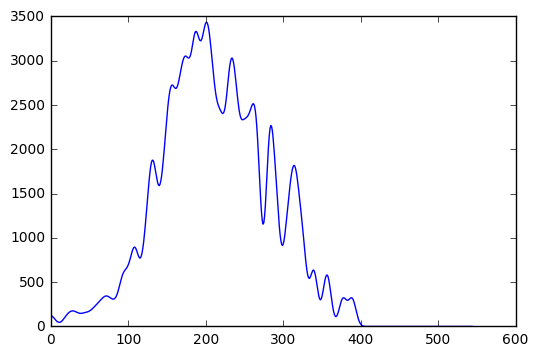

In [21]:
plot(gaussian_filter1d(np.argmax(widthDist,axis=1),5))

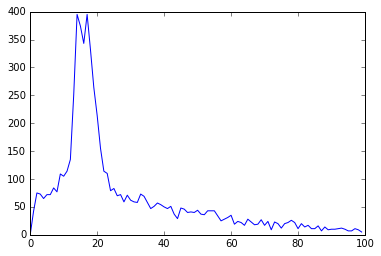

In [22]:
plot(np.sum(widthDist,axis=1)[:100])

In [194]:
pseudo_data_widths

[22,
 0,
 0,
 1,
 38,
 198,
 593,
 1090,
 1548,
 1912,
 2108,
 2156,
 2281,
 2165,
 2128,
 2143,
 1876,
 1964,
 1847,
 1767,
 1582,
 1435,
 1322,
 1182,
 1103,
 1018,
 972,
 967,
 802,
 783,
 794,
 721,
 700,
 650,
 626,
 564,
 529,
 530,
 469,
 477,
 442,
 416,
 402,
 378,
 375,
 333,
 320,
 314,
 297,
 266,
 253,
 245,
 233,
 211,
 228,
 209,
 206,
 186,
 177,
 167,
 139,
 152,
 143,
 148,
 137,
 122,
 113,
 119,
 122,
 106,
 111,
 135,
 90,
 104,
 95,
 92,
 91,
 95,
 96,
 89,
 89,
 92,
 74,
 84,
 77,
 67,
 69,
 71,
 67,
 82,
 70,
 63,
 67,
 80,
 66,
 63,
 57,
 64,
 58,
 67,
 63,
 66,
 66,
 55,
 64,
 56,
 49,
 63,
 35,
 52,
 58,
 50,
 47,
 63,
 44,
 54,
 44,
 44,
 51,
 52,
 47,
 40,
 39,
 50,
 40,
 51,
 46,
 41,
 43,
 50,
 41,
 35,
 42,
 42,
 46,
 33,
 34,
 32,
 35,
 36,
 30,
 40,
 37,
 34,
 34,
 39,
 26,
 42,
 34,
 29,
 42,
 27,
 32,
 27,
 31,
 31,
 39,
 41,
 35,
 31,
 27,
 33,
 26,
 34,
 28,
 29,
 24,
 34,
 26,
 26,
 31,
 29,
 28,
 29,
 29,
 21,
 28,
 28,
 20,
 30,
 26,
 18,
 22,
 

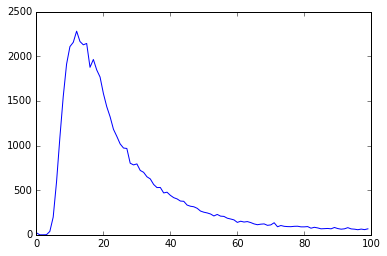

In [13]:
plot(pseudo_data_widths[:100])

In [23]:
sum(np.sum(widthDist,axis=1)[:25])

4049

In [24]:
np.sum(widthDist,axis=1)[:25]

array([  0,  42,  75,  73,  65,  72,  72,  84,  77, 109, 105, 114, 135,
       251, 395, 374, 343, 395, 332, 264, 214, 155, 114, 110,  79])

In [147]:
my_sigs = dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:]

In [160]:
np.max(my_sigs[widthDist[50,:],:],axis=1)

array([ 1.421278  ,  0.85725999,  0.70231003,  1.44606996,  1.44606996,
        0.93783402,  0.25862101,  1.44606996,  0.42549601,  0.45887101,
        0.405471  ,  0.492246  ,  0.23859601,  0.85725999,  1.44606996,
        0.64577103,  0.64577103,  0.19854601,  0.851062  ,  0.72090399,
        0.882052  ,  0.94403201,  0.89444798,  1.41507995,  1.421278  ,
        0.39879599,  0.683716  ,  0.93783402,  1.253932  ,  0.91304201,
        0.93783402,  0.37877101,  0.165171  ,  0.291996  ,  0.165171  ,
        0.56567103,  0.605721  ,  0.51894599,  0.43884599,  1.44606996,
        0.66512197,  0.17852101,  0.165171  ,  0.332046  ], dtype=float32)

In [196]:
maxes = []
for i in range(5,100):
    mynum = []
    for j in range(-5,5):
        mynum.append(np.max(my_sigs[widthDist[i+j,:],:],axis=1).tolist())
    #print(len([item for sublist in mynum for item in sublist]))
    maxes.append([item for sublist in mynum for item in sublist])

#[item for sublist in mynum for item in sublist]
#np.array(mynum).ravel()

In [201]:
maxes[94]

[0.7147060036659241,
 0.7518939971923828,
 1.2043479681015015,
 1.0555959939956665,
 0.18519599735736847,
 0.5790209770202637,
 0.26529601216316223,
 0.3987959921360016,
 1.1919519901275635,
 0.15849600732326508,
 0.7766860127449036,
 1.4460699558258057,
 1.4460699558258057,
 1.3345060348510742,
 0.7766860127449036,
 0.3120209872722626,
 0.3987959921360016,
 0.5723459720611572,
 1.229140043258667,
 0.6457710266113281,
 1.4460699558258057,
 0.4321709871292114,
 0.17852100729942322,
 0.16517099738121033,
 1.0803879499435425,
 0.9254379868507385,
 1.3345060348510742,
 0.19854600727558136,
 0.6257460117340088,
 0.844864010810852,
 1.4460699558258057,
 0.2185710072517395,
 0.17852100729942322,
 0.6837159991264343,
 1.4460699558258057,
 1.1795560121536255,
 0.7518939971923828,
 0.7704880237579346,
 0.6457710266113281,
 0.25194600224494934,
 1.4460699558258057,
 1.4460699558258057,
 0.733299970626831,
 0.18519599735736847,
 1.3097139596939087,
 1.2911200523376465,
 0.9502300024032593,
 0.3987

In [48]:
np.max(my_sigs[widthDist[150,:],:])

ValueError: max() arg is an empty sequence

In [58]:
np.(my_sigs[widthDist[150,:],:])

(array([], dtype=int64), array([], dtype=int64))

In [18]:
my_means = []
for ns in r_[1:545:1]:
    if len(my_sigs[widthDist[ns,:],:]) > 0:
        my_means.append(np.mean(np.max(my_sigs[widthDist[ns,:],:],axis=1)))
        #print(ns)
    else:
        my_means.append(0)
    #print(ns)


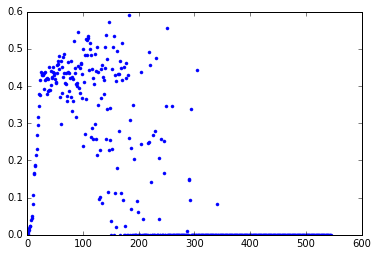

In [81]:
plot(r_[1:545:1],my_stds,'b.')

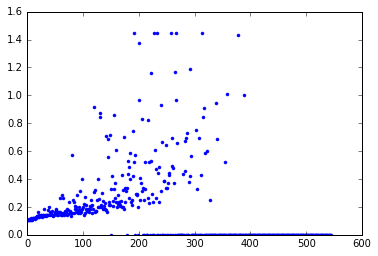

In [76]:
plot(r_[1:545:1],my_mins,'b.')

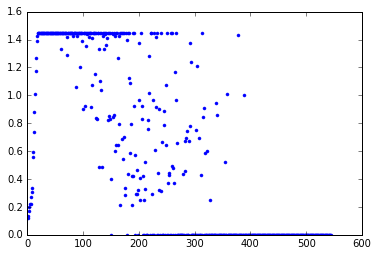

In [75]:
plot(r_[1:545:1],my_maxes,'b.')

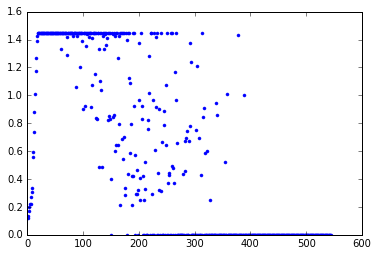

In [17]:
plot(r_[1:545:1][:],my_maxes[:],'b.')

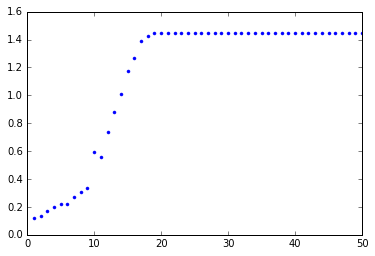

In [85]:
plot(r_[1:545:1][:50],my_maxes[:50],'b.')

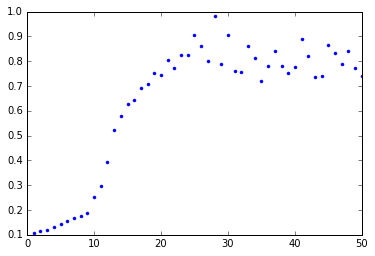

In [84]:
plot(r_[1:545:1][:50],my_means[:50],'b.')

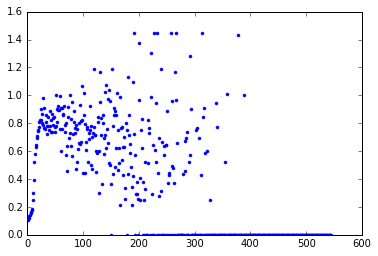

In [19]:
plot(r_[1:545:1][:],my_means[:],'b.')

In [193]:
pseudo_data_widths = []
for i in range(528):
    pseudo_data_widths.append(sum(sum(xtrain > 0,axis=1) == i))

In [86]:
#for ns in r_[1:545:1]:
#    print("max: " + str(np.mean(np.max(my_sigs[widthDist[ns,:],:],axis=1))))
    
    #      np.min(my_sigs[widthDist[ns,:],:],axis=1),
    #      np.mean(my_sigs[widthDist[ns,:],:],axis=1),
    #      np.std(my_sigs[widthDist[ns,:],:],axis=1))

(array([ 8.,  4.,  5.,  5.,  3.,  6.,  4.,  0.,  1.,  8.]),
 array([ 0.165171  ,  0.29326089,  0.42135079,  0.54944068,  0.67753058,
         0.80562048,  0.93371037,  1.06180027,  1.18989016,  1.31798006,
         1.44606996]),
 <a list of 10 Patch objects>)

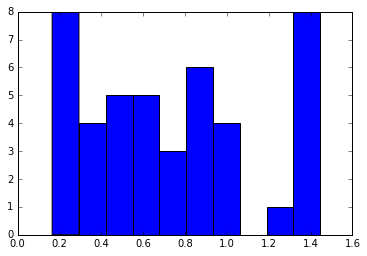

In [37]:
hist(np.max(my_sigs[widthDist[50,:],:],axis=1))

In [ ]:
(1.44607/ 0.0066749997999999994)+0.25528091

In [703]:
(1.439872 / 0.0066749997999999994)+0.25528091

215.96644842194513

In [ ]:
245

In [847]:
sum(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:] > 0.1,axis=1) > 30

array([False, False, False, ..., False, False, False], dtype=bool)

In [715]:
myset = np.array(list(set(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool].flatten())))

In [850]:
dist2 = np.sum(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:] > 0.1,axis=1)>15
dist2 = np.sum(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:][dist2],axis=1)

In [7]:
dist = np.sum(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:],axis=1)

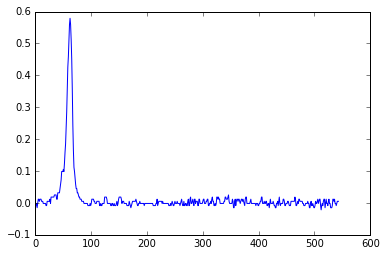

In [842]:
plot(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:][-3])

In [823]:
#raw.T.sum()

In [11]:
dist1 = dist[dist>0]

(array([ 136.,  853.,  763.,  430.,  366.,  272.,  257.,  220.,  181.,
         167.,  165.,  115.,  117.,  119.,  101.,   64.,   64.,   51.,
          49.,   49.,   60.,   41.,   35.,   31.,   27.,   25.,   15.,
          10.,   20.,    8.,   21.,    6.,   10.,    6.,    9.,   10.,
           9.,    6.,    4.,    6.,    7.,    8.,    3.,    3.,    3.,
           3.,    3.,    1.,    5.,    1.,    1.,    1.,    1.,    0.,
           3.,    3.,    1.,    1.,    0.,    1.,    0.,    2.,    1.,
           2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    1.,    0.,    1.,    2.,    0.,    1.,
           0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([   2.93784857,    5.49327446,    8.04870036,   10.60412626,
          13.15955215,   15.71497805,   18.27040395,   20.82582984,
          23.38125574,   25.93668164,   28.49210753,   31.04753343,
      

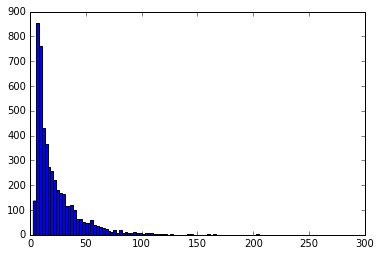

In [852]:
hist(dist2,100)

In [12]:
np.log(dist1)

array([ 1.5728153 ,  1.76269519,  1.67037284, ...,  2.09404063,
        0.63651007,  0.88536716], dtype=float32)

In [8]:
from sklearn import mixture

In [46]:
g = mixture.GMM(n_components=2,covariance_type='full')

In [47]:

X = np.array(np.log(dist1)).reshape(1, -1)

In [48]:
g.fit(X.T)

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

In [49]:
g.means_

array([[ 3.00010872],
       [ 1.91826881]])

In [55]:
print(g.weights_)
print(g.means_)

[ 0.46047491  0.53952509]
[[ 3.00010872]
 [ 1.91826881]]


In [44]:
tset = g.sample(4000)

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,
           1.,    2.,    2.,    3.,    5.,    4.,    4.,    5.,    5.,
           4.,    6.,    5.,    9.,    7.,   14.,   18.,   18.,   23.,
          14.,   27.,   29.,   38.,   55.,   47.,   56.,   66.,   60.,
          67.,   80.,   96.,   87.,  117.,   96.,  106.,  114.,  115.,
         121.,  109.,  126.,  134.,  108.,  134.,  145.,  127.,   86.,
         128.,  130.,   93.,  111.,   96.,   99.,   82.,   82.,   76.,
          67.,   82.,   53.,   53.,   50.,   48.,   34.,   32.,   24.,
          25.,   24.,   17.,   18.,   14.,    9.,   13.,    6.,    5.,
           6.,    3.,    3.,    3.,    2.,    8.,    2.,    3.,    1.,    1.]),
 array([ -2.20021734e+00,  -2.12173506e+00,  -2.04325278e+00,
         -1.96477050e+00,  -1.88628822e+00,  -1.80780594e+00,
         -1.72932366e+00,  -1.65084137e+00,  -1.57235909e+00,
         -1.49387681e+00

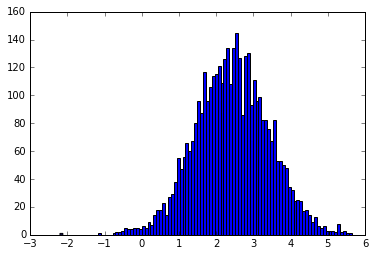

In [45]:
hist(tset,100)

In [13]:
import pymc3 as pm

In [14]:
W = np.array([0,0])

In [ ]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))

    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=np.log(dist1))

(17.990353, 9.8740759)

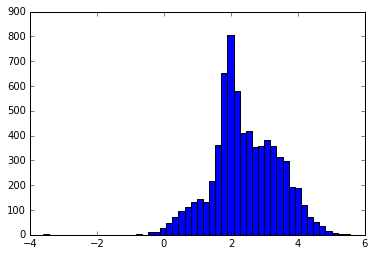

In [56]:
hist(np.log(dist1),50)
mean(dist1), median(dist1)

(17.982586, 9.8731737, 493, 479, 7002, 3)

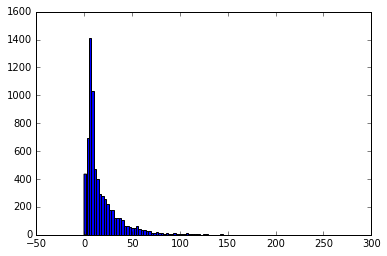

In [822]:
hist(dist, 100)
mean(dist), median(dist), sum(dist>50), sum(dist<2.5), len(dist), sum(dist<=0)

In [720]:
#myset.sort()
len(myset)

244

In [765]:
orgin[u'Data_1HZ'].items() #['ANCILLARY_DATA']

[(u'Packet_Data', <HDF5 group "/Data_1HZ/Packet_Data" (29 members)>),
 (u'Geolocation', <HDF5 group "/Data_1HZ/Geolocation" (2 members)>),
 (u'Transmit_Energy', <HDF5 group "/Data_1HZ/Transmit_Energy" (1 members)>),
 (u'Instrument_Settings',
  <HDF5 group "/Data_1HZ/Instrument_Settings" (19 members)>),
 (u'Engineering', <HDF5 group "/Data_1HZ/Engineering" (4 members)>),
 (u'Flags', <HDF5 group "/Data_1HZ/Flags" (7 members)>),
 (u'Time', <HDF5 group "/Data_1HZ/Time" (8 members)>),
 (u'DS_UTCTime_1', <HDF5 dataset "DS_UTCTime_1": shape (1288,), type "<f8">)]

In [771]:
(myset[1:]-myset[:-1])[-2]

0.0061980486

In [769]:
np.unique(myset[1:]-myset[:-1],return_counts=True)

(array([ 0.00619793,  0.00619799,  0.00619805,  0.00647801,  0.00667495,
         0.00667498,  0.00667499,  0.006675  ,  0.006675  ,  0.006675  ,
         0.006675  ,  0.006675  ,  0.006675  ,  0.086775  ], dtype=float32),
 array([29, 46, 52,  1,  2,  7,  6, 14,  5,  2,  3,  6, 69,  1]))

In [740]:
(myset / 0.066749997999999994)+0.25528091

array([ -2.67024732,  -1.37024713,  -1.27024722,  -1.17024732,
        -1.07024717,  -0.97024721,  -0.8702473 ,  -0.77024716,
        -0.6702472 ,  -0.57024717,  -0.47024721,  -0.37024719,
        -0.27024716,  -0.1702472 ,  -0.0702472 ,   0.02975282,
         0.12975281,   0.22975282,   0.32975283,   0.42975283,
         0.52975285,   0.62975281,   0.72975278,   0.82975286,
         0.92975289,   1.02975285,   1.12975287,   1.22975278,
         1.32975292,   1.42975283,   1.52975273,   1.62975287,
         1.72975278,   1.82975292,   1.92975283,   2.02975297,
         2.12975287,   2.22975302,   2.32975316,   2.42975283,
         2.52975297,   2.62975311,   2.72975302,   2.82975292,
         2.92975307,   3.02975297,   3.12975311,   3.22975302,
         3.32975292,   3.42975307,   3.52975321,   3.62975287,
         3.72975302,   3.82975316,   3.92975307,   4.02975273,
         4.12975311,   4.22975302,   4.32975292,   4.42975283,
         4.52975321,   4.62975311,   4.72975302,   4.82

In [791]:
#len(set(((myset / 0.0061980486)-7.31054688)[116:])) == len(myset[116:])
len(set(((myset / 0.0066749997999999994)+0.25528091)[:116])) == len(myset[:116])
myset[115],myset[116]


(0.65244597, 0.65892398)

In [793]:
((myset / 0.0066749997999999994)+0.25528091)[:]

array([ -29.        ,  -16.        ,  -15.00000095,  -14.00000095,
        -13.        ,  -12.00000095,  -11.00000095,  -10.        ,
         -9.00000095,   -7.99999952,   -7.00000048,   -6.        ,
         -5.        ,   -4.        ,   -3.        ,   -2.        ,
         -1.        ,    0.        ,    1.        ,    2.        ,
          3.00000024,    4.        ,    5.        ,    6.        ,
          7.00000048,    8.        ,    9.        ,    9.99999905,
         11.        ,   12.        ,   13.        ,   14.        ,
         15.        ,   16.        ,   17.00000191,   18.00000191,
         19.        ,   20.00000191,   21.00000191,   22.        ,
         23.00000191,   24.00000191,   25.        ,   26.00000191,
         27.00000191,   28.        ,   29.00000191,   30.00000191,
         31.        ,   32.        ,   33.        ,   34.        ,
         35.        ,   36.        ,   37.        ,   38.        ,
         39.        ,   40.        ,   40.99999619,   42.     

In [774]:
((myset / 0.0066749997999999994)+0.25528091)[:116]

array([-29.        , -16.        , -15.00000095, -14.00000095,
       -13.        , -12.00000095, -11.00000095, -10.        ,
        -9.00000095,  -7.99999952,  -7.00000048,  -6.        ,
        -5.        ,  -4.        ,  -3.        ,  -2.        ,
        -1.        ,   0.        ,   1.        ,   2.        ,
         3.00000024,   4.        ,   5.        ,   6.        ,
         7.00000048,   8.        ,   9.        ,   9.99999905,
        11.        ,  12.        ,  13.        ,  14.        ,
        15.        ,  16.        ,  17.00000191,  18.00000191,
        19.        ,  20.00000191,  21.00000191,  22.        ,
        23.00000191,  24.00000191,  25.        ,  26.00000191,
        27.00000191,  28.        ,  29.00000191,  30.00000191,
        31.        ,  32.        ,  33.        ,  34.        ,
        35.        ,  36.        ,  37.        ,  38.        ,
        39.        ,  40.        ,  40.99999619,  42.        ,
        43.        ,  44.        ,  45.        ,  46.  

In [728]:
np.round((myset / 0.0066749997999999994)+0.25528091,2)

array([ -29.        ,  -16.        ,  -15.        ,  -14.        ,
        -13.        ,  -12.        ,  -11.        ,  -10.        ,
         -9.        ,   -8.        ,   -7.        ,   -6.        ,
         -5.        ,   -4.        ,   -3.        ,   -2.        ,
         -1.        ,    0.        ,    1.        ,    2.        ,
          3.        ,    4.        ,    5.        ,    6.        ,
          7.        ,    8.        ,    9.        ,   10.        ,
         11.        ,   12.        ,   13.        ,   14.        ,
         15.        ,   16.        ,   17.        ,   18.        ,
         19.        ,   20.        ,   21.        ,   22.        ,
         23.        ,   24.        ,   25.        ,   26.        ,
         27.        ,   28.        ,   29.        ,   30.        ,
         31.        ,   32.        ,   33.        ,   34.        ,
         35.        ,   36.        ,   37.        ,   38.        ,
         39.        ,   40.        ,   41.        ,   42.     

In [709]:
np.array(set(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool].flatten()))

TypeError: 'set' object has no attribute '__getitem__'

In [707]:
np.array(set(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool].flatten()))/ 0.0066749997999999994)+0.25528091

TypeError: unsupported operand type(s) for /: 'set' and 'float'

In [60]:
len(noise_sub)

2408688

In [691]:
raw.ix[:,10].argmax()

'e5a4efd5b6c00ecdfb9e6a6991414313e459a17dfeb30443778065e724c56113'

In [695]:
raw.ix['e5a4efd5b6c00ecdfb9e6a6991414313e459a17dfeb30443778065e724c56113']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9         0.000000
10     3449.754175
11     4167.479262
12       13.964674
13        0.000000
14        0.000000
15        0.000000
16        0.000000
17        0.000000
18        0.000000
19        0.000000
20        0.000000
21        0.000000
22        0.000000
23        0.000000
24        0.000000
25        0.000000
26        0.000000
27        0.000000
28        0.000000
29        0.000000
          ...     
514       0.000000
515       0.000000
516       0.000000
517       0.000000
518       0.000000
519       0.000000
520       0.000000
521       0.000000
522       0.000000
523       0.000000
524       0.000000
525       0.000000
526       0.000000
527       0.000000
528       0.000000
529       0.000000
530       0.000000
531       0.000000
532       0.000000
533       0.000000
534       0.000000
535       0.

In [696]:
raw.ix[50]

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9         0.000000
10       64.572728
11      822.777801
12     3525.696110
13     2958.647825
14      251.195023
15        8.308625
16        0.000000
17        0.000000
18        0.000000
19        0.000000
20        0.000000
21        0.000000
22        0.000000
23        0.000000
24        0.000000
25        0.000000
26        0.000000
27        0.000000
28        0.000000
29        0.000000
          ...     
514       0.000000
515       0.000000
516       0.000000
517       0.000000
518       0.000000
519       0.000000
520       0.000000
521       0.000000
522       0.000000
523       0.000000
524       0.000000
525       0.000000
526       0.000000
527       0.000000
528       0.000000
529       0.000000
530       0.000000
531       0.000000
532       0.000000
533       0.000000
534       0.000000
535       0.

In [853]:
sum(gaussian_filter1d(raw.ix['e5a4efd5b6c00ecdfb9e6a6991414313e459a17dfeb30443778065e724c56113'].as_matrix(),.8))#+y_noise[4:])

7631.1981111086579

In [52]:
temp = dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][signals,:]

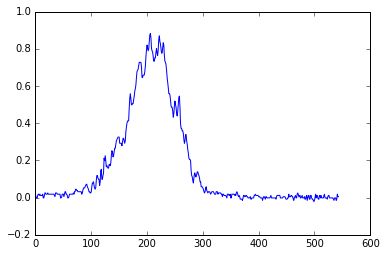

In [59]:
plot(temp[4111])

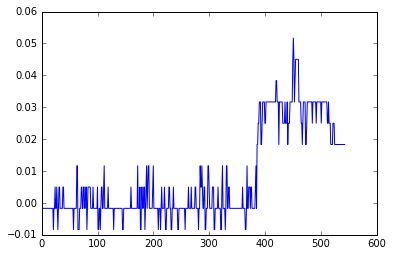

In [474]:
plot(noise.next())

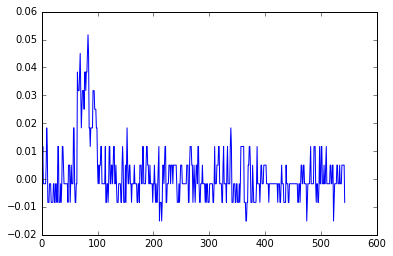

In [511]:
plot(noise.next())

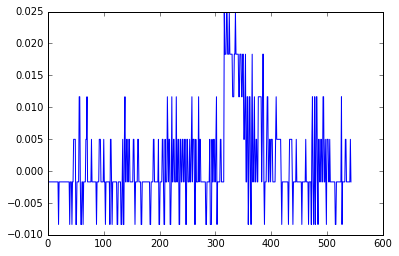

In [627]:
plot(noise.next())

In [46]:
sum(valid_bool)

16440

In [18]:
dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][0]

array([-0.001704  ,  0.004971  ,  0.011646  , -0.001704  , -0.001704  ,
       -0.001704  , -0.001704  , -0.008379  , -0.008379  , -0.001704  ,
       -0.001704  , -0.001704  , -0.001704  , -0.001704  , -0.001704  ,
       -0.015054  , -0.008379  , -0.008379  , -0.008379  , -0.008379  ,
       -0.015054  , -0.008379  , -0.001704  , -0.001704  ,  0.004971  ,
       -0.001704  , -0.001704  , -0.001704  , -0.001704  , -0.001704  ,
        0.011646  ,  0.004971  , -0.001704  , -0.008379  , -0.008379  ,
       -0.008379  , -0.015054  , -0.015054  ,  0.011646  ,  0.024996  ,
        0.031671  ,  0.031671  ,  0.011646  ,  0.004971  ,  0.031671  ,
        0.078396  ,  0.118446  ,  0.13847101,  0.165171  ,  0.21857101,
        0.31869599,  0.43884599,  0.53897101,  0.56567103,  0.532296  ,
        0.43884599,  0.33872101,  0.251946  ,  0.185196  ,  0.125121  ,
        0.098421  ,  0.071721  ,  0.045021  ,  0.024996  ,  0.018321  ,
        0.011646  ,  0.011646  ,  0.011646  ,  0.011646  , -0.00

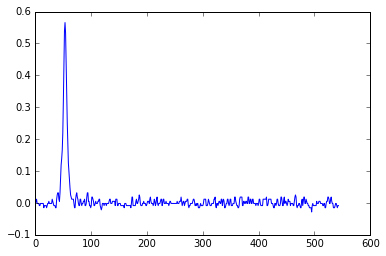

In [17]:
plot(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][0])

In [702]:
hist((dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool])

1.44607

In [699]:
(np.max(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool],axis=1) > 0.1)

array([ True,  True,  True, ..., False, False, False], dtype=bool)

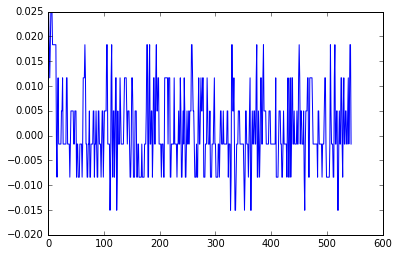

In [41]:
plot(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][valid_bool][7227])

In [190]:
test = dataset40['Time']['i_rec_ndx'][:] ==115713686

In [631]:
np.max(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][test][:,200:-1] - 
 dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][test][:,201:],axis=1)

array([ 0.033375  ,  0.033375  ,  0.0267    ,  0.033375  ,  0.0267    ,
        0.033375  ,  0.046725  ,  0.046725  ,  0.033375  ,  0.0267    ,
        0.020025  ,  0.020025  ,  0.020025  ,  0.020025  ,  0.020025  ,
        0.0267    ,  0.0267    ,  0.0267    ,  0.020025  ,  0.020025  ,
        0.0267    ,  0.0267    ,  0.020025  ,  0.020025  ,  0.0267    ,
        0.046725  ,  0.0267    ,  0.0267    ,  0.05340001,  0.020025  ,
        0.0267    ,  0.020025  ,  0.020025  ,  0.0267    ,  0.020025  ,
        0.0801    ,  0.0267    ,  0.020025  ,  0.03337499,  0.020025  ], dtype=float32)

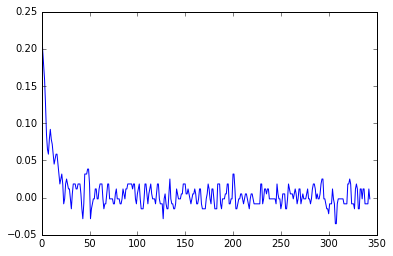

In [209]:
plot(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][test][7][200:])

In [69]:
#2290156 - 
r_[0:2290156:544][:-1]+460+544

array([   1004,    1548,    2092, ..., 2289068, 2289612, 2290156])

In [139]:
y_start

1382016

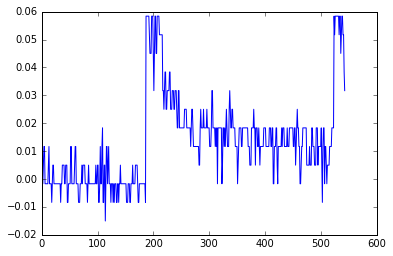

In [181]:
plot(y_noise[:])

In [183]:
4209*460

1936140

In [422]:
i = 0
for y_start in r_[0:2290156:544][:-1]:
    for j in range(460):
        y_noise = y[y_start + j:y_start + 544 + j]
        if max(np.abs(y_noise[:-1] - y_noise[1:])) < .045:
            i+=1
print(i)

1700612


In [425]:
y[2290156]

IndexError: index 2290156 is out of bounds for axis 0 with size 2290156

In [423]:
r_[0:2290156:544][-1]+459

2290155

In [420]:
r_[0:2290156:544]

array([      0,     544,    1088, ..., 2288608, 2289152, 2289696])

In [426]:
range(460)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


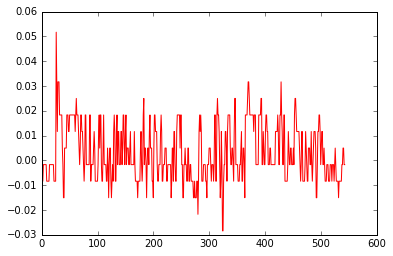

In [278]:
plot(y_noise[:],c='r')

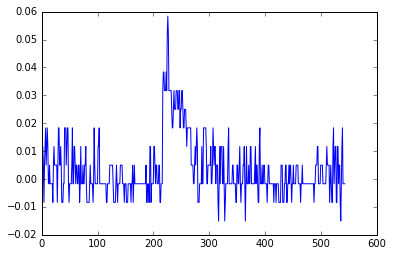

In [271]:
plot(y_noise[:])

In [319]:
max(np.abs(y_noise[:-1] - y_noise[1:]))

0.066749997

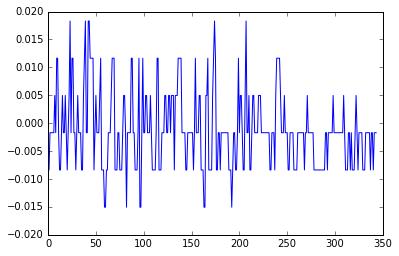

In [417]:
# Select random contiguous chunk
y_start = random.choice(r_[0:2290156:544][:-1]) + randint(0,460)
y_noise = y[y_start:y_start + 544]
if max(np.abs(y_noise[:-1] - y_noise[1:])) < .045:
    plot(y_noise[200:])
else:
    plot(y_noise[:],c='r')
#print(len(r_[0:2290156:544][:-1]))

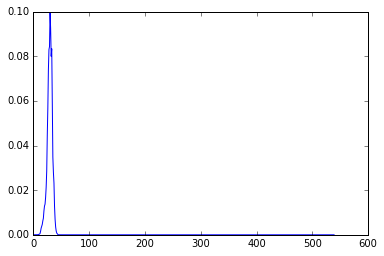

In [416]:
plot(xtest[1338])

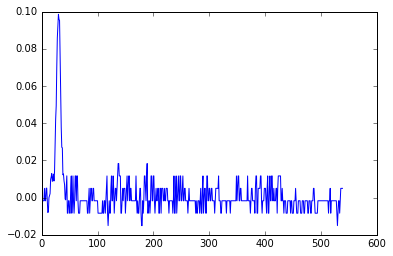

In [21]:
plot(gaussian_filter1d(xtest[1338],.8)+y_noise[4:])

In [190]:
y_start

2489891

9670


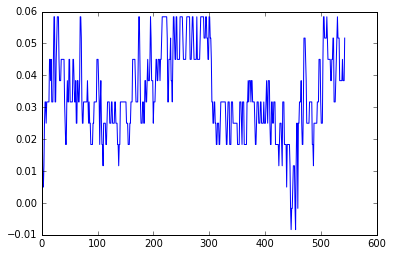

In [189]:
# Select random contiguous chunk
y_start = random.choice(r_[0:5260497:544][:-1]) + randint(0,17)
y_noise = y[y_start:y_start + 544]
plot(y_noise)
print(len(r_[0:5260497:544][:-1]))

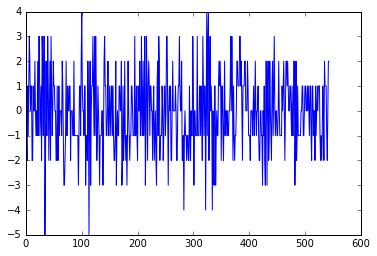

In [167]:
y_int=np.array((y_noise.ravel() / 0.0066749997999999994)+0.25528091, dtype=int)
#y_int=(y_noise.ravel() / 0.0066749997999999994)+0.25528091

plot(y_int)
y_int = y_int + 7

In [176]:
estMu = Uniform('estMean',lower=1,upper=30,value=median(y_int))

@pymc.deterministic()
def noise1(mu=estMu):
    return np.random.poisson(mu)-np.random.poisson(mu)

@pymc.deterministic()
def noise2(mu=estMu):
    return np.random.poisson(mu)

volts = Poisson('volts',mu=estMu,value=y,observed=True)

In [177]:
#model_noise = dict(estMu=estMu,tau=tau,volts=volts,sigma=sigma,noise=noise)

model_noise = dict(estMu=estMu,volts=volts,noise1=noise1,noise2=noise2)#,sim=sim,up=up,sub=sub)
#model_noise = dict(estMu=estMu,volts=volts,noise=noise,sim=sim)

In [178]:
m = MCMC(model_noise)

In [179]:
m.draw()

In [180]:
m.sample(iter=10000, burn=1000, thin=2)

 [-                 4%                  ] 466 of 10000 complete in 17.6 secHalting at iteration  480  of  10000


In [170]:
estMu = Uniform('estMean',lower=-0.01,upper=0.01,value=median(y))
sigma = Uniform('sigma',lower=0.001,upper=0.02,value=std(y))

@pymc.deterministic()
def tau(sigma=sigma):
    return 1./(sigma**2)

@pymc.deterministic()
def noise(tau=tau,mu=estMu):
    return np.random.normal(mu,sigma,1)

#estTau = Uniform('precision', lower=0.1, upper=100000.0)

volts_pos = Normal('volts',mu=estMu,tau=tau,value=y,observed=True)

#volts = Poisson('volts', mu=estMu, value=disasters_array, observed=True)

In [ ]:
estMu = Uniform('estMean',lower=-0.01,upper=0.01,value=median(y))
sigma = Uniform('sigma',lower=0.001,upper=0.02,value=std(y))

@pymc.deterministic()
def tau(sigma=sigma):
    return 1./(sigma**2)

@pymc.deterministic()
def noise(tau=tau,mu=estMu):
    return np.random.normal(mu,sigma,1)

#estTau = Uniform('precision', lower=0.1, upper=100000.0)

volts_pos = Normal('volts',mu=estMu,tau=tau,value=y,observed=True)

#volts = Poisson('volts', mu=estMu, value=disasters_array, observed=True)

In [16]:
import pymc
from scipy.stats import ks_2samp

In [142]:
import statsmodels.api as sm
from pandas.tools.plotting import autocorrelation_plot

In [26]:
arModel = sm.tsa.AR(y)

In [27]:
results = arModel.fit()

In [107]:
mod = sm.tsa.arma_generate_sample(results.params**-1,y[10:20],60)

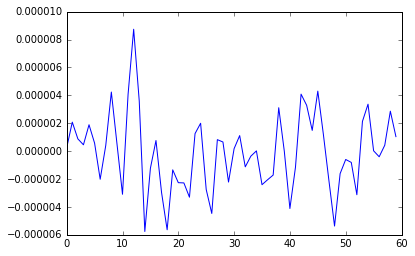

In [108]:
plot(mod)

In [62]:
results.params

array([  1.11342155e-04,   8.74456570e-01,  -3.73317019e-01,
         1.03941573e-01,  -2.15386643e-02,   1.08705096e-01,
        -7.81027241e-02,   1.46644442e-01,   3.10566678e-02,
        -1.55346706e-01,   8.24737883e-02,   3.15586243e-02,
         5.37709190e-02,  -1.02782649e-01,   8.42246365e-02,
        -7.96170103e-02,   1.59116785e-01,  -1.44781497e-01,
         3.19535200e-02,   5.12474018e-02,  -1.27792070e-02,
        -1.40413455e-02,   1.01060465e-02,  -4.47902854e-02,
         1.42486325e-01,  -1.28709388e-01,   4.90759796e-02,
        -4.19958289e-02,   6.83478381e-02,   5.32078068e-04,
        -5.09247747e-02,   8.91957503e-03,   1.07344607e-01,
        -1.14424801e-01,   8.23375408e-02,  -8.98026739e-02,
         1.43875491e-01,  -1.34622988e-01,   8.96907996e-02,
        -8.69175401e-02,   7.13843001e-02,  -3.72895010e-02])

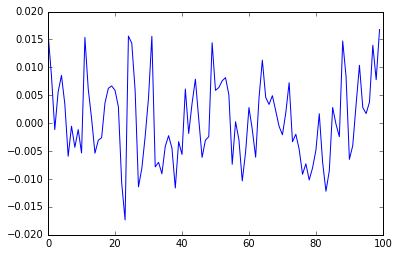

In [59]:
plot(results.predict()[:100])

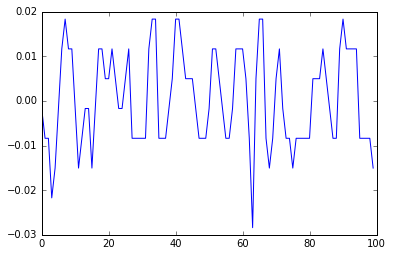

In [40]:
plot(y[:100])

In [14]:
std(y)

0.0093798619

In [15]:
median(y)

-0.0017040001

In [16]:
1/(std(y)**2)

11365.985917028604

In [333]:
estMu = Uniform('estMean',lower=-0.01,upper=0.01)

@pymc.deterministic()
def estTau(value=0.015):
    return -np.log(abs(value))

#estTau = Uniform('precision', lower=0.1, upper=100000.0)

volts = Normal('volts',mu=estMu,tau=estTau,value=y,observed=True)

#volts = Poisson('volts', mu=estMu, value=disasters_array, observed=True)

In [348]:
estMu = Uniform('estMean',lower=-0.01,upper=0.01,value=median(y))
sigma = Uniform('sigma',lower=0.001,upper=0.02,value=std(y))

@pymc.deterministic()
def tau(sigma=sigma):
    return 1./(sigma**2)

@pymc.deterministic()
def noise(tau=tau,mu=estMu):
    return np.random.normal(mu,sigma,1)

#estTau = Uniform('precision', lower=0.1, upper=100000.0)

volts_pos = Normal('volts',mu=estMu,tau=tau,value=y,observed=True)

#volts = Poisson('volts', mu=estMu, value=disasters_array, observed=True)

In [112]:
y_int= y_int + 7


In [241]:
estMu = Uniform('estMean',lower=1,upper=30,value=median(y_int))
#sigma = Uniform('sigma',lower=0.001,upper=0.02,value=std(y))

#@pymc.deterministic()
#def tau(sigma=sigma):
#    return 1./(sigma**2)

@pymc.deterministic()
def noise1(mu=estMu):
    return np.random.poisson(mu)-np.random.poisson(mu)

@pymc.deterministic()
def noise2(mu=estMu):
    return np.random.poisson(mu)

#estTau = Uniform('precision', lower=0.1, upper=100000.0)

volts = Poisson('volts',mu=estMu,value=y,observed=True)
#up = Poisson('up',mu=estMu) 
#sub = Poisson('sub',mu=estMu)
#sim = up - sub

#volts = Poisson('volts', mu=estMu, value=disasters_array, observed=True)

In [242]:
#model_noise = dict(estMu=estMu,tau=tau,volts=volts,sigma=sigma,noise=noise)
model_noise = dict(estMu=estMu,volts=volts,noise1=noise1,noise2=noise2)#,sim=sim,up=up,sub=sub)

In [243]:
m = MCMC(model_noise)

In [342]:
m.draw()

In [244]:
m.sample(iter=100000, burn=10000, thin=2)

 [-----------------100%-----------------] 100000 of 100000 complete in 15.2 sec

(0, 300, -0.1, 0.1)

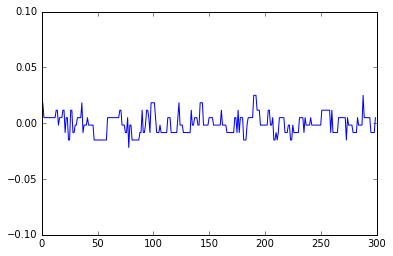

In [245]:
temp=((np.array(m.trace('noise1')[-1500:-1200],dtype=float)-0.25528091)*0.0066749997999999994)
plot(temp)
axis((0,300,-.1,.1))

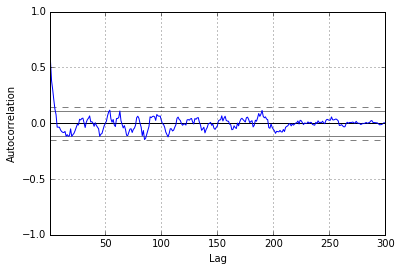

In [246]:
autocorrelation_plot(temp)

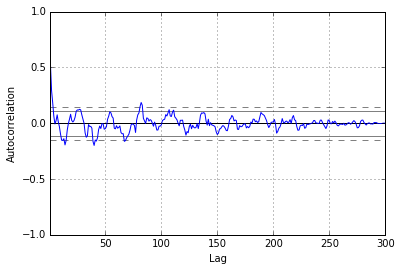

In [240]:
autocorrelation_plot(temp)

(0, 300, -0.1, 0.1)

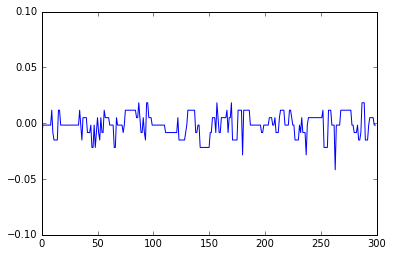

In [239]:
temp=((np.array(m.trace('noise1')[-1500:-1200],dtype=float)-0.25528091)*0.0066749997999999994)
plot(temp)
axis((0,300,-.1,.1))

(0, 300, -0.1, 0.1)

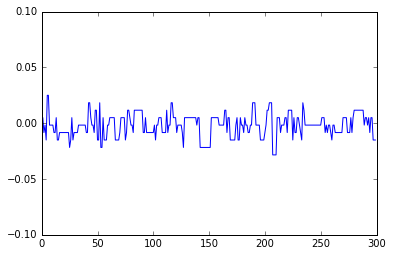

In [237]:
temp=((np.array(m.trace('noise1')[-1200:-900],dtype=float)-0.25528091)*0.0066749997999999994)
plot(temp)
axis((0,300,-.1,.1))

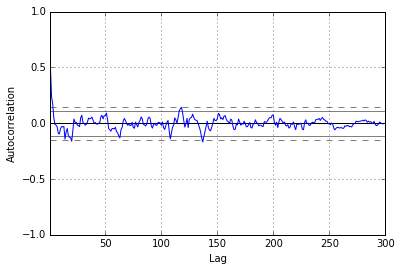

In [238]:
autocorrelation_plot(temp)


In [ ]:
#2 above

(0, 300, -0.1, 0.1)

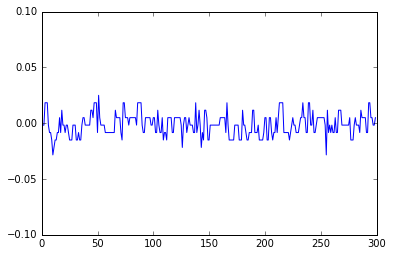

In [231]:
temp=((np.array(m.trace('noise1')[-1200:-900],dtype=float)-0.25528091)*0.0066749997999999994)
plot(temp)
axis((0,300,-.1,.1))

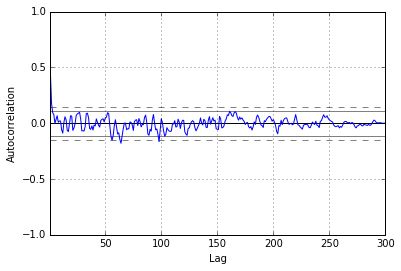

In [232]:
autocorrelation_plot(temp)


In [ ]:
## 3 above

(0, 300, -0.1, 0.1)

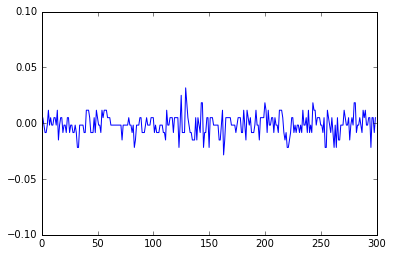

In [228]:
temp=((np.array(m.trace('noise1')[-1200:-900],dtype=float)-0.25528091)*0.0066749997999999994)
plot(temp)
axis((0,300,-.1,.1))

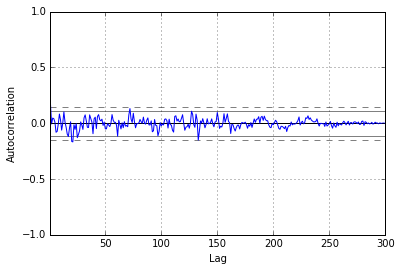

In [229]:
autocorrelation_plot(temp)


In [ ]:
##4 below, 5 above

(0, 300, -0.1, 0.1)

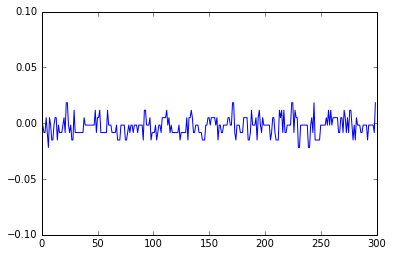

In [222]:
temp=((np.array(m.trace('noise1')[-1200:-900],dtype=float)-0.25528091)*0.0066749997999999994)
plot(temp)
axis((0,300,-.1,.1))


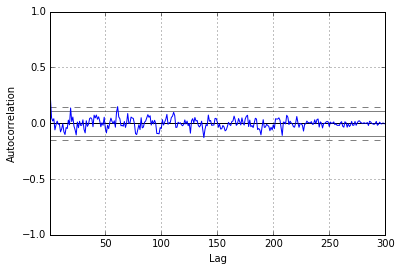

In [223]:
autocorrelation_plot(temp)


In [210]:
temp=((np.array(m.trace('noise1')[-1800:-1500],dtype=float)-0.25528091)*0.0066749997999999994)

(0, 300, -0.1, 0.1)

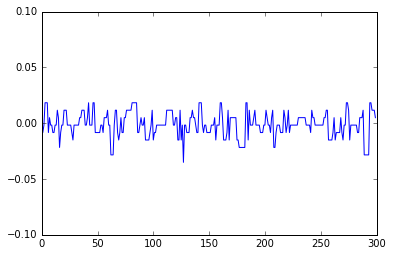

In [211]:
plot(temp)
axis((0,300,-.1,.1))

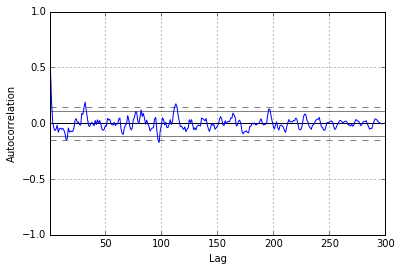

In [212]:
autocorrelation_plot(temp)

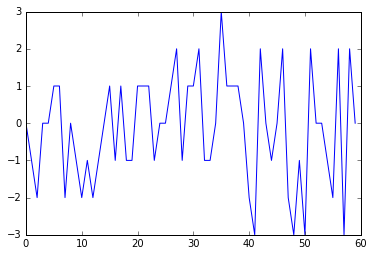

In [134]:
plot(m.trace(up)[-60:]-m.trace(sub)[-60:])

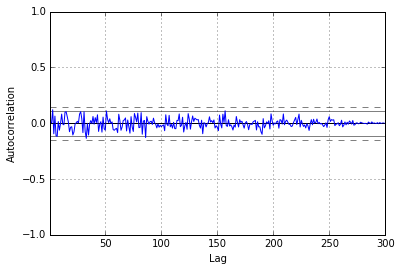

In [166]:
autocorrelation_plot(temp)

(0, 300, -0.1, 0.1)

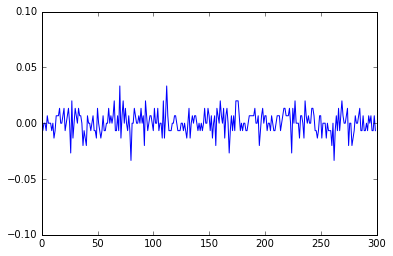

In [165]:
plot(temp)
axis((0,300,-.1,.1))

In [178]:
temp=((np.array(m.trace('noise1')[-300:],dtype=float)-0.25528091)*0.0066749997999999994 -
     (np.array(m.trace('noise2')[-300:],dtype=float)-0.25528091)*0.0066749997999999994)

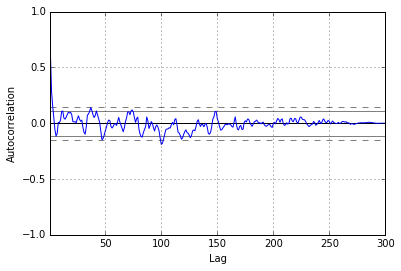

In [180]:
autocorrelation_plot(temp)

(0, 300, -0.1, 0.1)

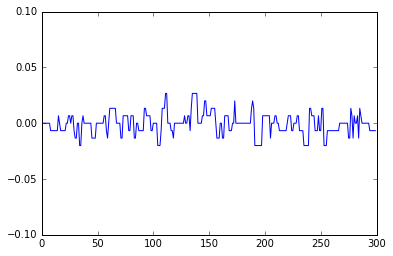

In [179]:
plot(temp)
axis((0,300,-.1,.1))

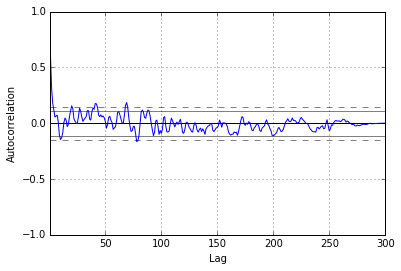

In [173]:
autocorrelation_plot(temp)

(0, 300, -0.1, 0.1)

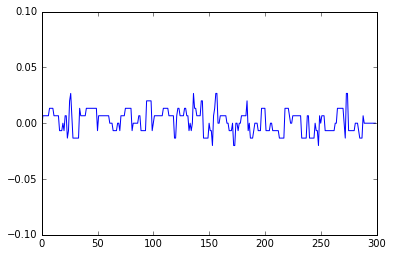

In [172]:
plot(temp)
axis((0,300,-.1,.1))

In [171]:
temp=((np.array(m.trace('noise1')[-600:-300],dtype=float)-0.25528091)*0.0066749997999999994 -
     (np.array(m.trace('noise2')[-600:-300],dtype=float)-0.25528091)*0.0066749997999999994)

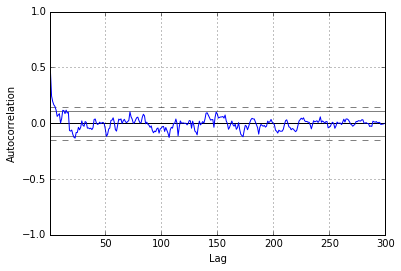

In [163]:
autocorrelation_plot(temp)

(0, 300, -0.1, 0.1)

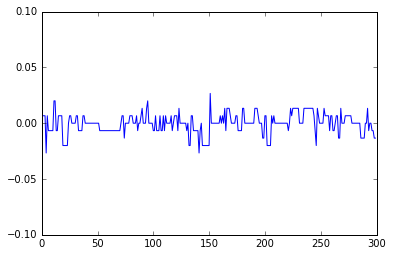

In [162]:
plot(temp)
axis((0,300,-.1,.1))

(0, 300, -0.1, 0.1)

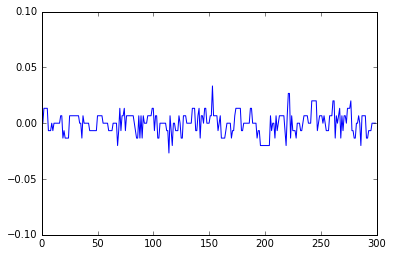

In [156]:
plot(temp)
axis((0,300,-.1,.1))

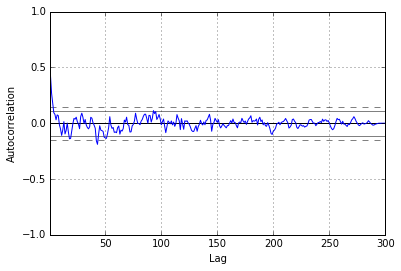

In [157]:
autocorrelation_plot(temp)

(0, 300, -0.1, 0.1)

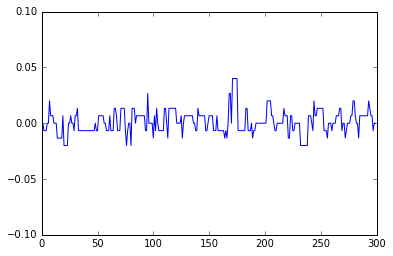

In [150]:
plot(temp)
axis((0,300,-.1,.1))

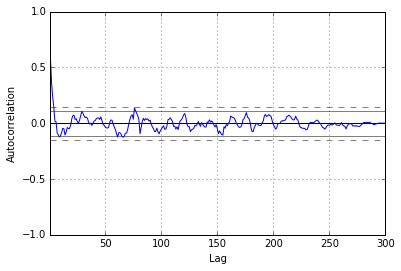

In [151]:
autocorrelation_plot(temp)

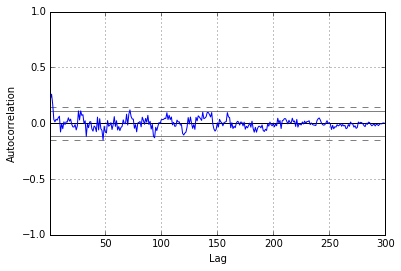

In [143]:
autocorrelation_plot(temp)

In [503]:
m.trace(sim)[-20:]

array([0, 2, 1, 0, 2, 1, 0, 0, 2, 1, 1, 2, 0, 2, 2, 0, 0, 4, 0, 1])

In [434]:
m.summary()


estMean:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.0              0.0              0.0                    [ 1.  1.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.0              1.0             1.0            1.0           1.0
	

noise:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.007            1.003            0.013                  [ 0.  3.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.0              0.0             1.0            2.0           3.0
	


Plotting estMean
Plotting noise


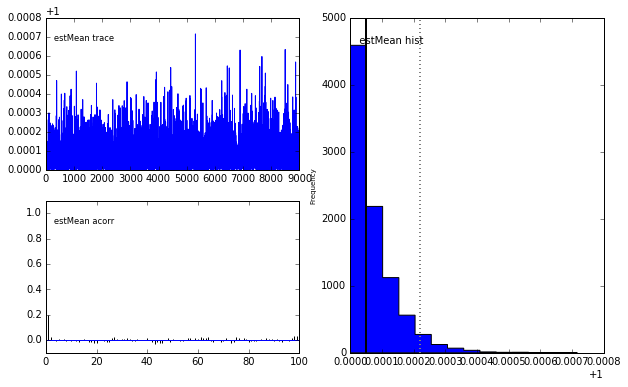

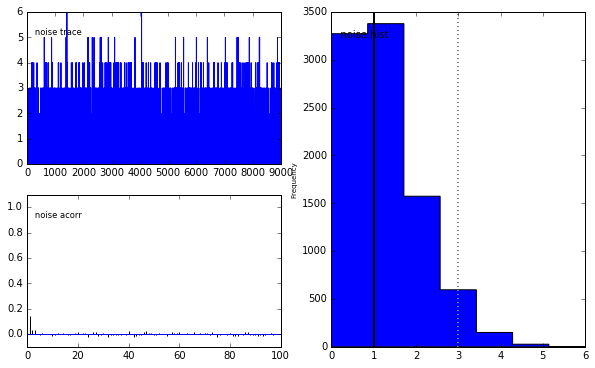

In [435]:
pymc.Matplot.plot(m)

In [353]:
m.summary()


estMean:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.001            0.0              0.0              [ 0.     0.001]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.0              0.001           0.001          0.001         0.001
	

noise:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.0              0.009            0.0              [-0.018  0.019]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.018           -0.006          0.0            0.007         0.019
	

tau:
 
	Mean             SD               MC Error        95% HPD interval
	---------------------

Plotting estMean
Plotting noise_0
Plotting tau
Plotting sigma


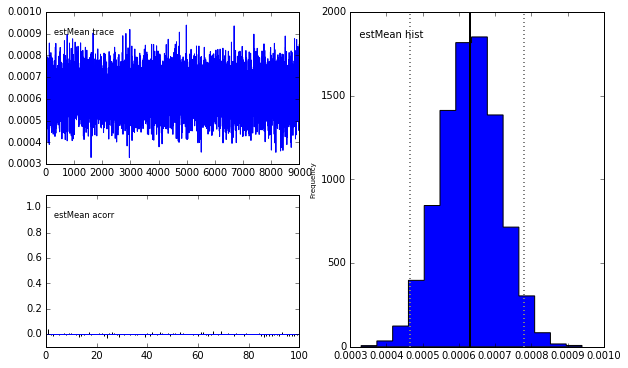

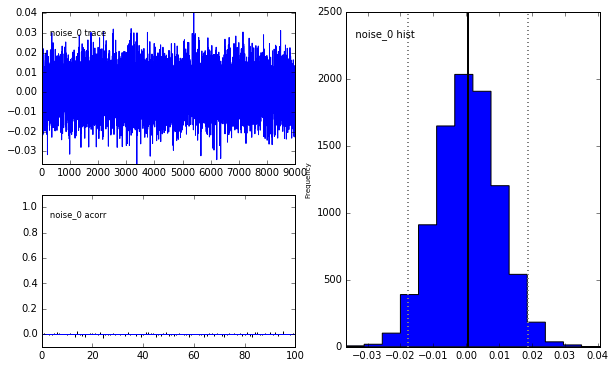

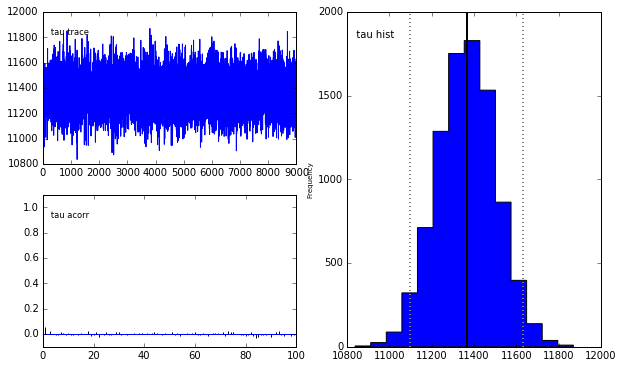

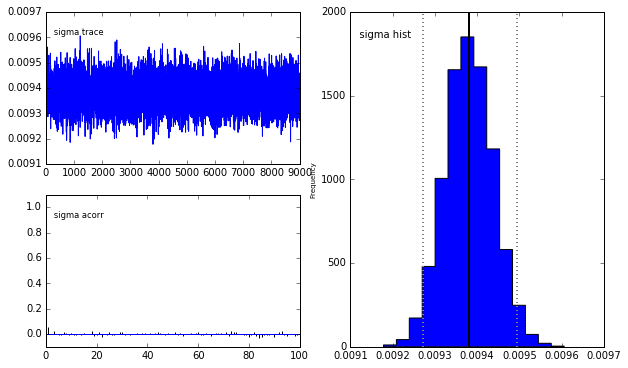

In [356]:
pymc.Matplot.plot(m)

In [392]:
m.stats()

{'estMean': {'95% HPD interval': array([ 0.00046388,  0.00078097]),
  'mc error': 8.2860736079649971e-07,
  'mean': 0.00063031495984695212,
  'n': 9000,
  'quantiles': {2.5: 0.00046852758832103159,
   25: 0.00057589304731550238,
   50: 0.00063156778731618705,
   75: 0.00068525235602750242,
   97.5: 0.00078649277843545972},
  'standard deviation': 8.11184748242398e-05},
 'noise': {'95% HPD interval': array([-0.01772803,  0.01877116]),
  'mc error': 8.7452038827883551e-05,
  'mean': 0.0003563561861867527,
  'n': 9000,
  'quantiles': {2.5: -0.017737303209741938,
   25: -0.0059609718670282589,
   50: 0.00042913479935528657,
   75: 0.006687666648008528,
   97.5: 0.018768308470067004},
  'standard deviation': 0.0093712330295667758},
 'sigma': {'95% HPD interval': array([ 0.00927161,  0.00949376]),
  'mc error': 7.0450275750395065e-07,
  'mean': 0.0093809215395755253,
  'n': 9000,
  'quantiles': {2.5: 0.0092699056919823414,
   25: 0.009341799230401,
   50: 0.0093803220992709629,
   75: 0.0094

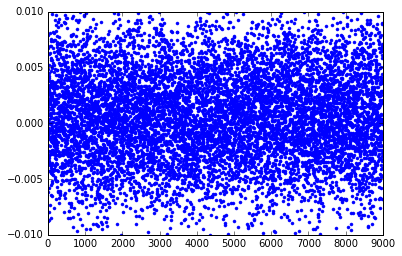

In [338]:
plot(m.trace(estMu)[:],'b.')

(0, 300, -0.1, 0.2)

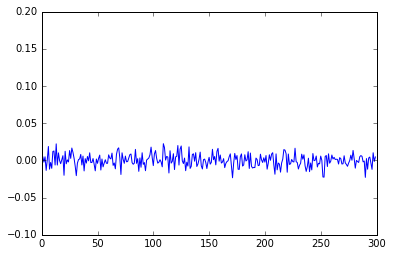

In [358]:
plot(m.trace('noise')[-300:])
axis((0,300,-.1,0.2))

(0, 300, -0.1, 0.2)

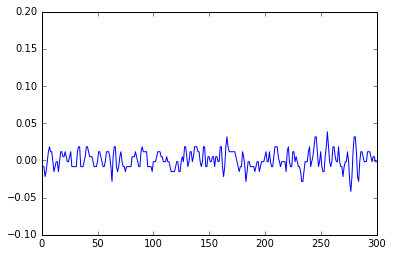

In [287]:
plot(noise_sub[noise_sub <.06].ravel())
axis((0,300,-.1,0.2))

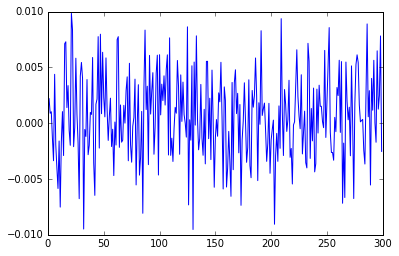

In [339]:
plot(m.trace(estMu)[1000:1300])

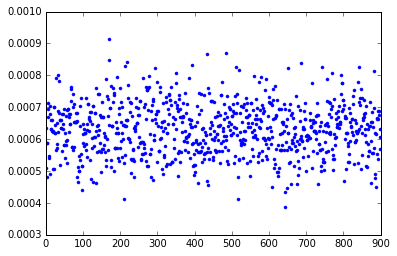

In [281]:
plot(m.trace(estMu)[:],'b.')

In [ ]:
estMu = Normal('estMean',mu=0.01,tau=0.01)
    
volts = Uniform('volts',mu=estMu,values=y,observed=True)

#volts = Poisson('volts', mu=estMu, value=disasters_array, observed=True)

In [141]:
noise_model = dict(y=noise_sub[noise_sub <.06].ravel())

In [142]:
m = MCMC(noise_model)

In [151]:
m.sample(iter=10000, burn=1000, thin=1)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.1 sec

In [174]:
x = (uniform.rvs(0,.015,544)+
     uniform.rvs(0,.015,544)+
     uniform.rvs(0,.015,544)+
     uniform.rvs(0,.015,544)-.03)

In [175]:
ks_2samp(y,x)

Ks_2sampResult(statistic=0.23490385953316872, pvalue=9.1512296526437666e-26)

(array([  2.00000000e+00,   7.50000000e+01,   4.60000000e+01,
          3.08500000e+03,   5.56500000e+03,   3.76200000e+03,
          8.43000000e+02,   7.60000000e+01,   4.90000000e+01,
          2.50000000e+01]),
 array([-0.048429, -0.037749, -0.027069, -0.016389, -0.005709,  0.004971,
         0.015651,  0.026331,  0.037011,  0.047691,  0.058371]),
 <a list of 10 Patch objects>)

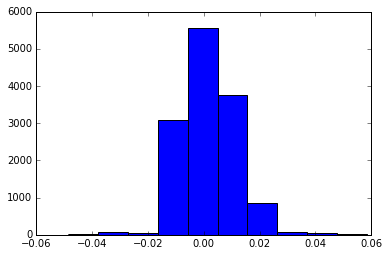

In [189]:
hist(y,10)

(0, 300, -0.1, 0.2)

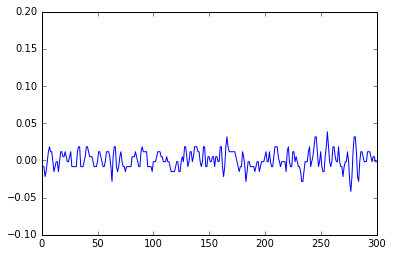

In [186]:
plot(noise_sub[noise_sub <.06].ravel())
axis((0,300,-.1,0.2))

In [394]:
max(noise_sub.ravel())

1.006012

In [398]:
set(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][:].ravel())

{-0.195279,
 -0.108504,
 -0.101829,
 -0.095154002,
 -0.088478997,
 -0.081804,
 -0.075129002,
 -0.068453997,
 -0.061779,
 -0.055103999,
 -0.048429001,
 -0.041754,
 -0.035078999,
 -0.028403999,
 -0.021729,
 -0.015054,
 -0.0083790002,
 -0.0017040001,
 0.0049709999,
 0.011646,
 0.018321,
 0.024995999,
 0.031670999,
 0.038346,
 0.045021001,
 0.051695999,
 0.058371,
 0.065045998,
 0.071721002,
 0.078396,
 0.085070997,
 0.091746002,
 0.098421,
 0.105096,
 0.111771,
 0.118446,
 0.125121,
 0.131796,
 0.13847101,
 0.145146,
 0.151821,
 0.15849601,
 0.165171,
 0.171846,
 0.17852101,
 0.185196,
 0.191871,
 0.19854601,
 0.205221,
 0.211896,
 0.21857101,
 0.225246,
 0.231921,
 0.23859601,
 0.245271,
 0.251946,
 0.25862101,
 0.26529601,
 0.27197099,
 0.27864599,
 0.285321,
 0.291996,
 0.29867101,
 0.30534601,
 0.31202099,
 0.31869599,
 0.325371,
 0.332046,
 0.33872101,
 0.34539601,
 0.35207099,
 0.35874599,
 0.365421,
 0.372096,
 0.37877101,
 0.38544601,
 0.39212099,
 0.39879599,
 0.405471,
 0.412146

In [110]:
y_int=(noise_sub[noise_sub <.06].ravel() / 0.0066749997999999994)+0.25528091

In [406]:
y_int = np.array(y_int,dtype=int)

In [401]:
29+216

245

In [400]:
(-0.195279 / 0.0066749997999999994)+0.25528091

-29.00000086543916

In [403]:
(1.439872 / 0.0066749997999999994)+0.25528091

215.96644842194513

In [380]:
wnumbs

{-0.048429001,
 -0.041754,
 -0.035078999,
 -0.028403999,
 -0.021729,
 -0.015054,
 -0.0083790002,
 0.0049709999,
 0.011646,
 0.018321,
 0.024995999,
 0.031670999,
 0.038346,
 0.045021001,
 0.051695999,
 0.058371}

In [386]:
numbs = set(y)
nset = []
while len(numbs) > 0:
    nset.append(numbs.pop())
numbs = np.array(nset)
(numbs / 0.0066749997999999994)+0.25528091

array([ 0.        , -1.        , -4.        ,  5.        ,  4.        ,
       -7.00000048, -3.        ,  8.        ,  7.00000048, -2.        ,
       -5.        ,  3.00000024,  2.        ,  1.        ,  6.        ,
        9.        , -6.        ], dtype=float32)

In [387]:
sort((numbs / 0.0066749997999999994)+0.25528091)


array([-7.00000048, -6.        , -5.        , -4.        , -3.        ,
       -2.        , -1.        ,  0.        ,  1.        ,  2.        ,
        3.00000024,  4.        ,  5.        ,  6.        ,  7.00000048,
        8.        ,  9.        ], dtype=float32)

In [389]:
np.array(sort((numbs / 0.0066749997999999994)+0.25528091),dtype=int)

array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [393]:
mean(m.trace('estMean')[:])

0.00063031495984695212

In [369]:
( -0.015054 +0.0066749997999999994+0.0066749997999999994+
    0.0066749997999999994+0.0066749997999999994+0.0066749997999999994)

0.018320998999999998

In [360]:
set(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][test][18][200:])

{-0.015054, -0.0083790002, -0.0017040001, 0.0049709999, 0.011646, 0.018321}

In [446]:
from pandas.tools.plotting import autocorrelation_plot

/usr/local/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


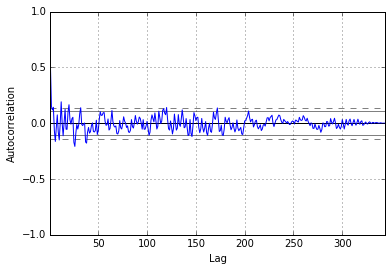

In [448]:
autocorrelation_plot(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][test][18][200:])
#axis((0,300,-.1,.1))

(0, 300, -0.1, 0.1)

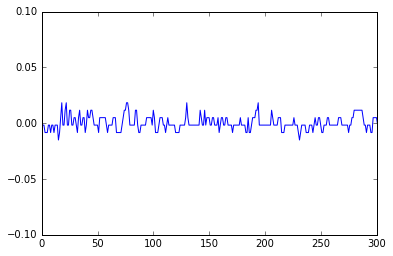

In [184]:
plot(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][test][18][200:])
axis((0,300,-.1,.1))

(0, 300, -0.1, 0.1)

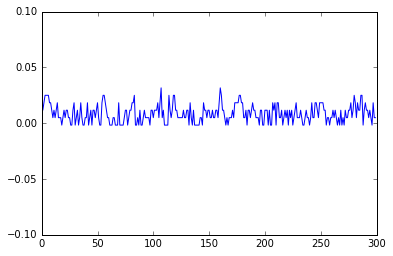

In [486]:
plot((np.array(gaussian_filter1d((m.trace('noise')[-300:]),.8),dtype=float)+
      np.array((m.trace('noise')[-600:-300]),dtype=float)-
      0.25528091)*0.0066749997999999994)
axis((0,300,-.1,.1))

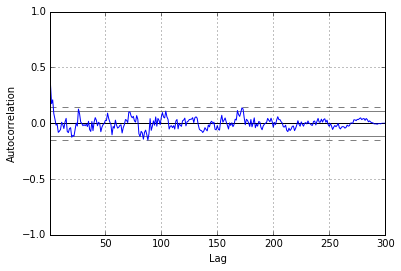

In [485]:
autocorrelation_plot((np.array(gaussian_filter1d((m.trace('noise')[-300:]),.8),dtype=float)+
      np.array((m.trace('noise')[-600:-300]),dtype=float)-
      0.25528091)*0.0066749997999999994)

(0, 300, -0.1, 0.1)

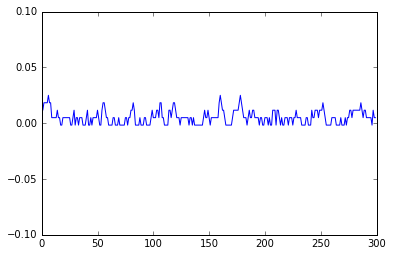

In [473]:
plot((np.array(gaussian_filter1d((m.trace('noise')[-300:]),.8),dtype=float)+
      np.array(gaussian_filter1d((m.trace('noise')[-600:-300]),.8),dtype=float)-
      0.25528091)*0.0066749997999999994)
axis((0,300,-.1,.1))

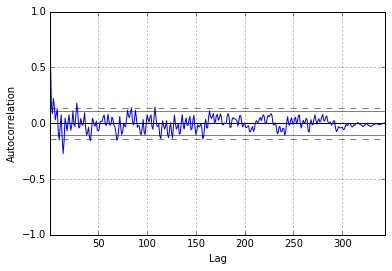

In [449]:
autocorrelation_plot(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][test][16][200:])

(0, 300, -0.1, 0.1)

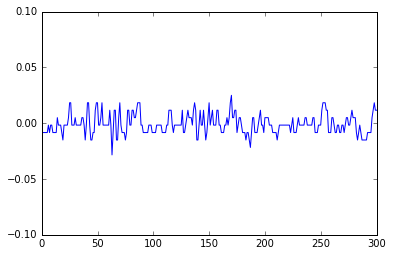

In [441]:
plot(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][test][16][200:])
axis((0,300,-.1,.1))

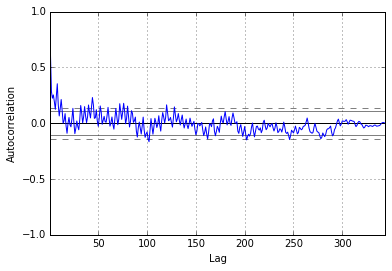

In [509]:
autocorrelation_plot(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][test][22][200:])

(0, 300, -0.1, 0.1)

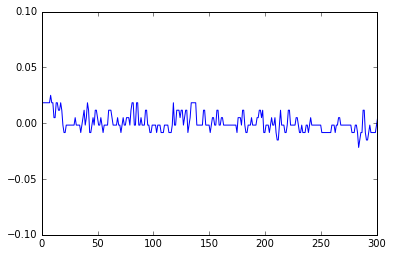

In [510]:
plot(dataset40['Waveform']['RecWaveform']['r_rng_wf'][:][test][22][200:])
axis((0,300,-.1,.1))

In [462]:
temp=(np.array(m.trace('noise')[-600:-300],dtype=float)-0.25528091)*0.0066749997999999994

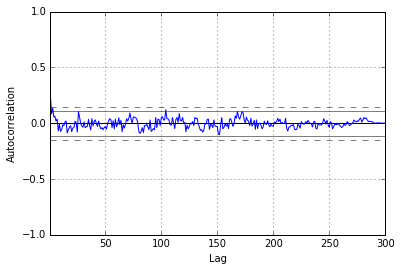

In [511]:
autocorrelation_plot(temp)

(0, 300, -0.1, 0.1)

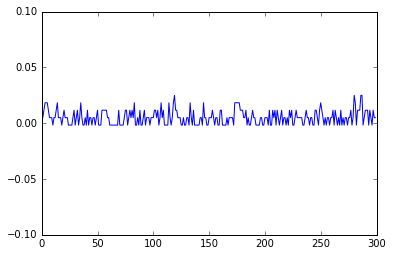

In [512]:
plot(temp)
axis((0,300,-.1,.1))

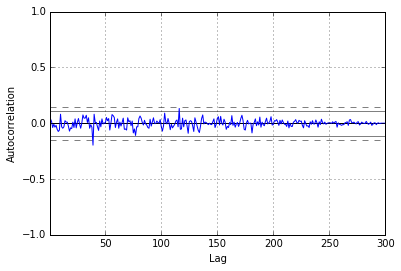

In [457]:
autocorrelation_plot(temp)

(0, 300, -0.1, 0.1)

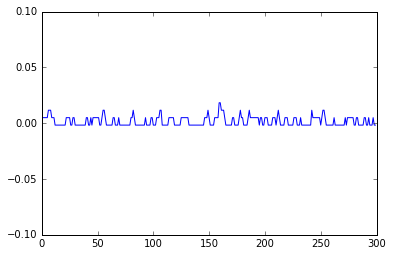

In [467]:
plot((np.array(gaussian_filter1d((m.trace('noise')[-300:]),.8),dtype=float)+
      (m.trace('noise')[-300:])-
      0.25528091)*0.0066749997999999994)
axis((0,300,-.1,.1))

(0, 300, -0.1, 0.1)

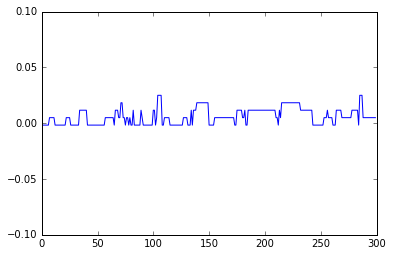

In [520]:
plot((np.array(m.trace('noise')[-600:-300],dtype=float)-
      0.25528091)*0.0066749997999999994)
axis((0,300,-.1,.1))

(0, 300, -0.1, 0.1)

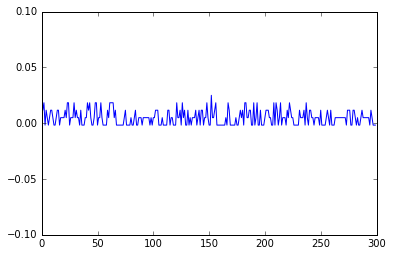

In [522]:
plot((np.array(m.trace('noise')[-600:-300],dtype=float)-
      0.25528091)*0.0066749997999999994)
axis((0,300,-.1,.1))

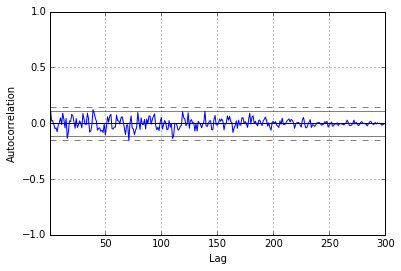

In [523]:
autocorrelation_plot((np.array(m.trace('noise')[-600:-300],dtype=float)-
      0.25528091)*0.0066749997999999994)

In [528]:
m.sample(iter=100000, burn=10000, thin=3)

 [-----------------100%-----------------] 100000 of 100000 complete in 25.1 sec

(0, 300, -0.1, 0.1)

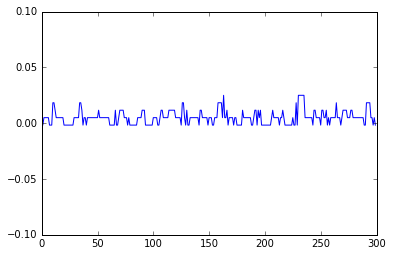

In [529]:
#thin = 3
plot((np.array(m.trace('noise')[-600:-300],dtype=float)-
      0.25528091)*0.0066749997999999994)
axis((0,300,-.1,.1))

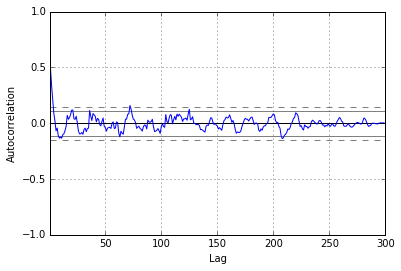

In [530]:
#thin = 3
autocorrelation_plot((np.array(m.trace('noise')[-600:-300],dtype=float)-
      0.25528091)*0.0066749997999999994)

(0, 300, -0.1, 0.1)

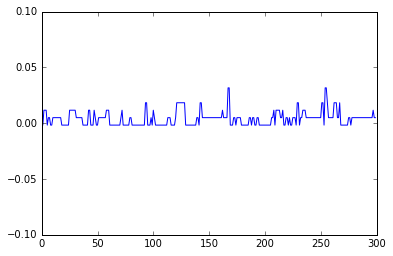

In [526]:
#thin = 2
plot((np.array(m.trace('noise')[-600:-300],dtype=float)-
      0.25528091)*0.0066749997999999994)
axis((0,300,-.1,.1))

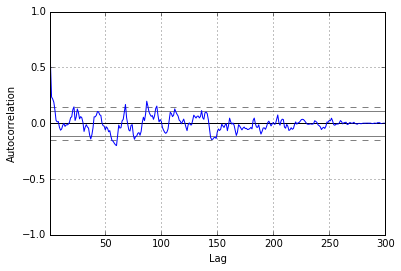

In [525]:
#thin = 2
autocorrelation_plot((np.array(m.trace('noise')[-600:-300],dtype=float)-
      0.25528091)*0.0066749997999999994)

(0, 300, -0.1, 0.1)

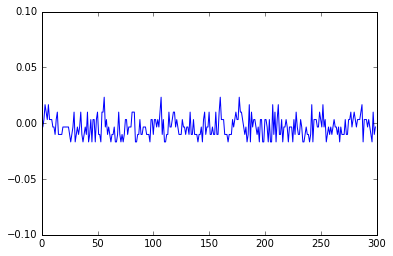

In [445]:
plot((
((np.array(m.trace('noise')[-600:-300]-1,dtype=float)-
      0.25528091)*0.0066749997999999994)+
((np.array(m.trace('noise')[-300:]-1,dtype=float)-
      0.25528091)*0.0066749997999999994)))
axis((0,300,-.1,.1))

AttributeError: 'Poisson' object has no attribute 'c'

In [88]:
from scipy.ndimage.filters import gaussian_filter1d

(0, 300, -0.1, 0.1)

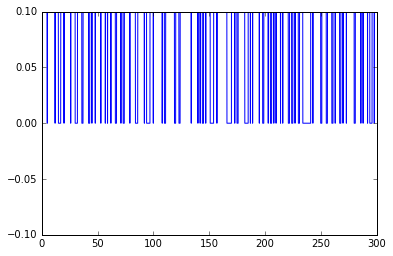

In [461]:
plot(m.trace('noise')[-300:])
axis((0,300,-.1,0.1))

(0, 300, -0.1, 0.1)

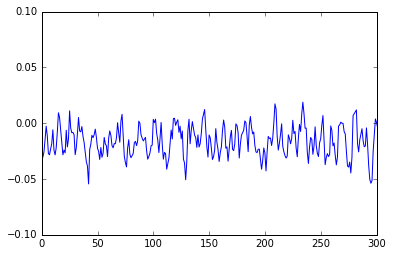

In [183]:
plot(gaussian_filter1d((norm.rvs(0,.015,544)+uniform.rvs(0,.015,544)+
                        norm.rvs(0,.015,544)),.8)+
                         uniform.rvs(0,.015,544)-.03)
axis((0,300,-.1,.1))

(0, 300, -0.1, 0.5)

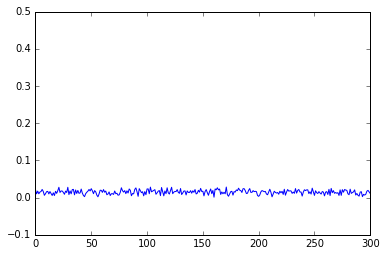

In [84]:
plot(uniform.rvs(0,.015,544)+uniform.rvs(0,.015,544))
axis((0,300,-.1,.5))

(0, 600, 0, 0.5)

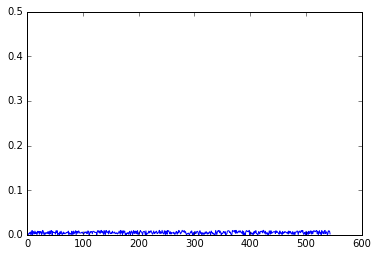

In [25]:
plot(uniform.rvs(0,.01,544))
axis((0,600,0,.5))